#### setup

In [6]:
import pandas as pd
import numpy as np
import warnings
from itertools import product, combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  
import itertools
warnings.filterwarnings("ignore")

%matplotlib inline

In [7]:
def load_df_from_file(verbose=True):
    """
    Load the raw dataset with minor mods
    """
    file_path = './event_labels_1_18_2025_last_N_days.csv'
    data = pd.read_csv(file_path)
    
    if verbose is True:
        print(f"num unique artists - {len(data.act.unique())}")

    # Replace inf and -inf with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    return data

#### load training dataset

$$
\mathbf{z}_i 
= \left[ \bar{\mu}_i, \ \bar{\tilde{\mu}}_i, \ \overline{\text{Max}}_i, \ \overline{\text{Min}}_i, 
\ \alpha_i, \ \beta_i \right]^\top,
$$

$$
\mathcal{D}_{\alpha \beta} 
= f\left( \mathcal{D}_{\text{basic}} \right)
= \left\{ \left( \mathbf{z}_i, y_i \right) \right\}_{i=1}^n.
$$

In [3]:
df = load_df_from_file()

print(df.columns)
print(f"unique events - {df.event_id.nunique()}")
print(f"unique artists - {df.act.nunique()}")
display(df)

num unique artists - 955
Index(['event_id', 'date', 'act', 'average_price', 'median_price',
       'lowest_price', 'highest_price', 'listing_count', 'score', 'popularity',
       'difference_days', 'alpha', 'beta'],
      dtype='object')
unique events - 22303
unique artists - 954


,event_id,date,act,average_price,median_price,lowest_price,highest_price,listing_count,score,popularity,difference_days,alpha,beta
0,5142994,2023-07-15 19:00:00,The Avett Brothers,202.642857,173.571429,57.285714,1564.571429,549.142857,0.568714,0.764429,0.0,1.409503,13.206386
1,5182871,2023-07-19 19:30:00,Matchbox Twenty,616.357143,475.642857,190.428571,3484.357143,68.285714,0.532643,0.755714,0.0,0.834239,5.617368
2,5182872,2023-07-21 19:30:00,Matchbox Twenty,510.928571,380.428571,80.142857,4118.500000,223.571429,0.552071,0.753857,0.0,0.936707,7.844355
3,5182873,2023-07-16 19:00:00,Matchbox Twenty,222.428571,165.928571,41.928571,3724.785714,433.928571,0.617786,0.803286,0.0,0.993188,19.271456
4,5182874,2023-07-30 19:30:00,Matchbox Twenty,224.285714,168.928571,35.785714,3435.571429,333.571429,0.508071,0.752500,0.0,1.046152,17.822236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23057,6373878,2024-02-27 19:00:00,Veeze,83.500000,75.142857,62.714286,143.142857,17.071429,0.435714,0.729429,0.0,0.572832,1.643692
23058,6374293,2024-03-02 21:00:00,Shrek Rave,92.928571,78.214286,53.000000,176.142857,7.857143,0.319643,0.669143,1.0,0.534114,1.113135
23059,6378358,2024-03-02 20:30:00,Everclear,99.428571,86.714286,62.785714,391.142857,535.571429,0.374643,0.694500,1.0,0.820659,6.533274
23060,6380083,2024-03-02 20:30:00,Gimme Gimme Disco,70.428571,61.928571,35.571429,113.214286,11.142857,0.249857,0.635500,1.0,0.438882,0.538709


#### Paper Section 3.4 - show $\alpha$ $\beta$ RF model improvements

In [6]:
# This execution is slow
# To mediate this I have included the ability to 
# save and load the data generated for post-processing analysis below
# if loading, this cell can be skipped

loaded_below = True
if not loaded_below:

    data = load_df_from_file()
    X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
    y_full = data["act"] 

    # Define the feature subsets
    subset_indices = [0, 1, 2, 3]  
    subset_indices2 = [0, 1, 2, 3, 4, 5]

    # Create the Cartesian product
    cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])

    # Remove the rows where act1 == act2
    df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']]
    df_act_cartesian_product = df_act_cartesian_product.reset_index(drop=True)
    print(f"All Artist Combos Length - {len(df_act_cartesian_product)}")

    act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]

    # To store results for each pairwise model
    results = []

    # Initialize counters for total correct predictions
    total_correct = {
        'subset': 0,
        'subset_const': 0,
        'subset2': 0,
        'subset2_const': 0
    }
    total_samples = 0

    break_after = 20000
    num_iter = 0

    all_models = {
        'subset': [],
        'subset_const': [],
        'subset2': [],
        'subset2_const': []
    }

    def train_evaluate_model(X_train, X_test, y_train, y_test, feature_subset, add_constants=False):
        # Select the subset of features
        X_train_subset = X_train.iloc[:, feature_subset].copy()
        X_test_subset = X_test.iloc[:, feature_subset].copy()

        if add_constants:
            # Add 20 constant features with the same value (e.g., zero)
            num_constants = 20
            const_value = 0
            for i in range(num_constants):
                X_train_subset[f'const_{i}'] = const_value
                X_test_subset[f'const_{i}'] = const_value

        # Train the model
        model = RandomForestClassifier(random_state=42, 
                                       class_weight='balanced', 
                                       max_features=2,
                                       max_depth=100,
                                       n_estimators=100)
        model.fit(X_train_subset, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        correct_predictions = np.sum(y_pred == y_test)

        return accuracy, correct_predictions, model

    # Iterate over each pair of acts
    for act_1, act_2 in act_pairs:
        # Filter data for the current pair of acts
        pair_mask = (y_full == act_1) | (y_full == act_2)
        X_pair_full = X_full[pair_mask]
        y_pair = y_full[pair_mask].replace({act_1: 0, act_2: 1})  # Binary labels

        # Split the data
        X_train_full, X_test_full, y_train, y_test = train_test_split(
            X_pair_full, y_pair, test_size=0.2, random_state=42
        )

        # Keep track of total samples
        total_samples += len(y_test)

        # Train and evaluate models
        # 1) Subset without constants
        acc1, correct1, model_1 = train_evaluate_model(X_train_full, X_test_full, y_train, 
                                                       y_test, subset_indices, add_constants=False)
        total_correct['subset'] += correct1
        all_models['subset'].append(model_1)

        # 2) Subset2 without constants
        acc2, correct2, model_2 = train_evaluate_model(X_train_full, X_test_full, 
                                                       y_train, y_test, subset_indices2, add_constants=False)
        total_correct['subset2'] += correct2
        all_models['subset2'].append(model_2)

        # Calculate improvements
        improvement_between_no_const = acc2 - acc1  # Improvement of subset_indices2 over subset_indices without constants

        # Store the results
        results.append({
            "act Pair": f"{act_1} vs {act_2}",
            "Accuracy Subset1 Only": acc1,
            "Accuracy Subset2 Only": acc2,
            "Improvement (Subset2 vs Subset1) No Const": improvement_between_no_const,
            "Number of Test Examples": len(X_test_full),
            "Number of Train Examples": len(X_train_full)
        })

        num_iter += 1
        if num_iter >= break_after:
            break

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Improvement (Subset2 vs Subset1) No Const', ascending=False)
    display(results_df)

num unique artists - 955
All Artist Combos Length - 909162


,act Pair,Accuracy Subset1 Only,Accuracy Subset2 Only,Improvement (Subset2 vs Subset1) No Const,Number of Test Examples,Number of Train Examples
15891,Johnny Mathis vs Amon Amarth,0.333333,1.000000,0.666667,3,12
15804,Johnny Mathis vs Ryan Beatty,0.333333,1.000000,0.666667,6,23
16017,Johnny Mathis vs Slowdive,0.333333,1.000000,0.666667,6,23
15281,Johnny Mathis vs Staind,0.000000,0.600000,0.600000,5,16
14103,Parmalee vs VNV Nation,0.142857,0.714286,0.571429,7,25
...,...,...,...,...,...,...
12444,Salebarbes vs Wizkid,1.000000,0.500000,-0.500000,2,6
13328,Salebarbes vs Oliver Anthony,1.000000,0.500000,-0.500000,2,7
2191,Collective Soul vs Charley Crockett,0.750000,0.250000,-0.500000,8,29
9570,Banda MS vs Frankie Valli And The Four Seasons,0.666667,0.111111,-0.555556,9,34


##### Use this to speed things up if already run

In [8]:
import pickle

#results_df.to_csv("results_df_2_6_2024.csv", index=False)
results_df = pd.read_csv("results_df_2_6_2024.csv")

# Save the data from the cell above because generating it is slow
# with open("total_correct.pkl", "wb") as file:
#     pickle.dump(total_correct, file)

# Load the data from previous runs because generating it is slow
with open("total_correct.pkl", "rb") as file:
    total_correct = pickle.load(file)
    
print(total_correct)

# The code below is still slow but still faster than the full process above
# consider hard coding total_samples to make it faster or serializing it with
# the other items
data = load_df_from_file()
X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
y_full = data["act"] 

# Define the feature subsets
subset_indices = [0, 1, 2, 3]  
subset_indices2 = [0, 1, 2, 3, 4, 5]

# Create the Cartesian product
cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])

# Remove the rows where act1 == act2
df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']]
df_act_cartesian_product = df_act_cartesian_product.reset_index(drop=True)
print(f"All Artist Combos Length - {len(df_act_cartesian_product)}")

act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]
total_samples = 0
num_iter = 0
break_after = 20000
for act_1, act_2 in act_pairs:
    # Filter data for the current pair of acts
    pair_mask = (y_full == act_1) | (y_full == act_2)
    X_pair_full = X_full[pair_mask]
    y_pair = y_full[pair_mask].replace({act_1: 0, act_2: 1})  # Binary labels

    # Split the data
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_pair_full, y_pair, test_size=0.2, random_state=42
    )
    
    # Keep track of total samples
    total_samples += len(y_test)
    
    num_iter += 1
    if num_iter >= break_after:
        break
        
print(f"total samples - {total_samples}")

{'subset': 160999, 'subset_const': 0, 'subset2': 163478, 'subset2_const': 0}
num unique artists - 955
All Artist Combos Length - 909162
total samples - 194720


##### Average number of test set examples

In [4]:
# Extract unique acts from the "act Pair" column
unique_acts = set()
results_df['act Pair'].str.split(' vs ').apply(unique_acts.update)
print(len(unique_acts))

print("Average number of train and test examples")
print(results_df['Number of Train Examples'].mean())
print(results_df['Number of Test Examples'].mean())

954
Average number of train and test examples
36.93765
9.736


##### Plots from the paper

Overall Performance:
Total Correct Predictions with Subset1 Only: 160999/194720
Total Correct Predictions with Subset2 Only: 163478/194720
Subset2 vs Subset1 No Const:
Num times Subset2 improved: 4488
Num times Subset2 degraded: 2773
Num times same: 12739


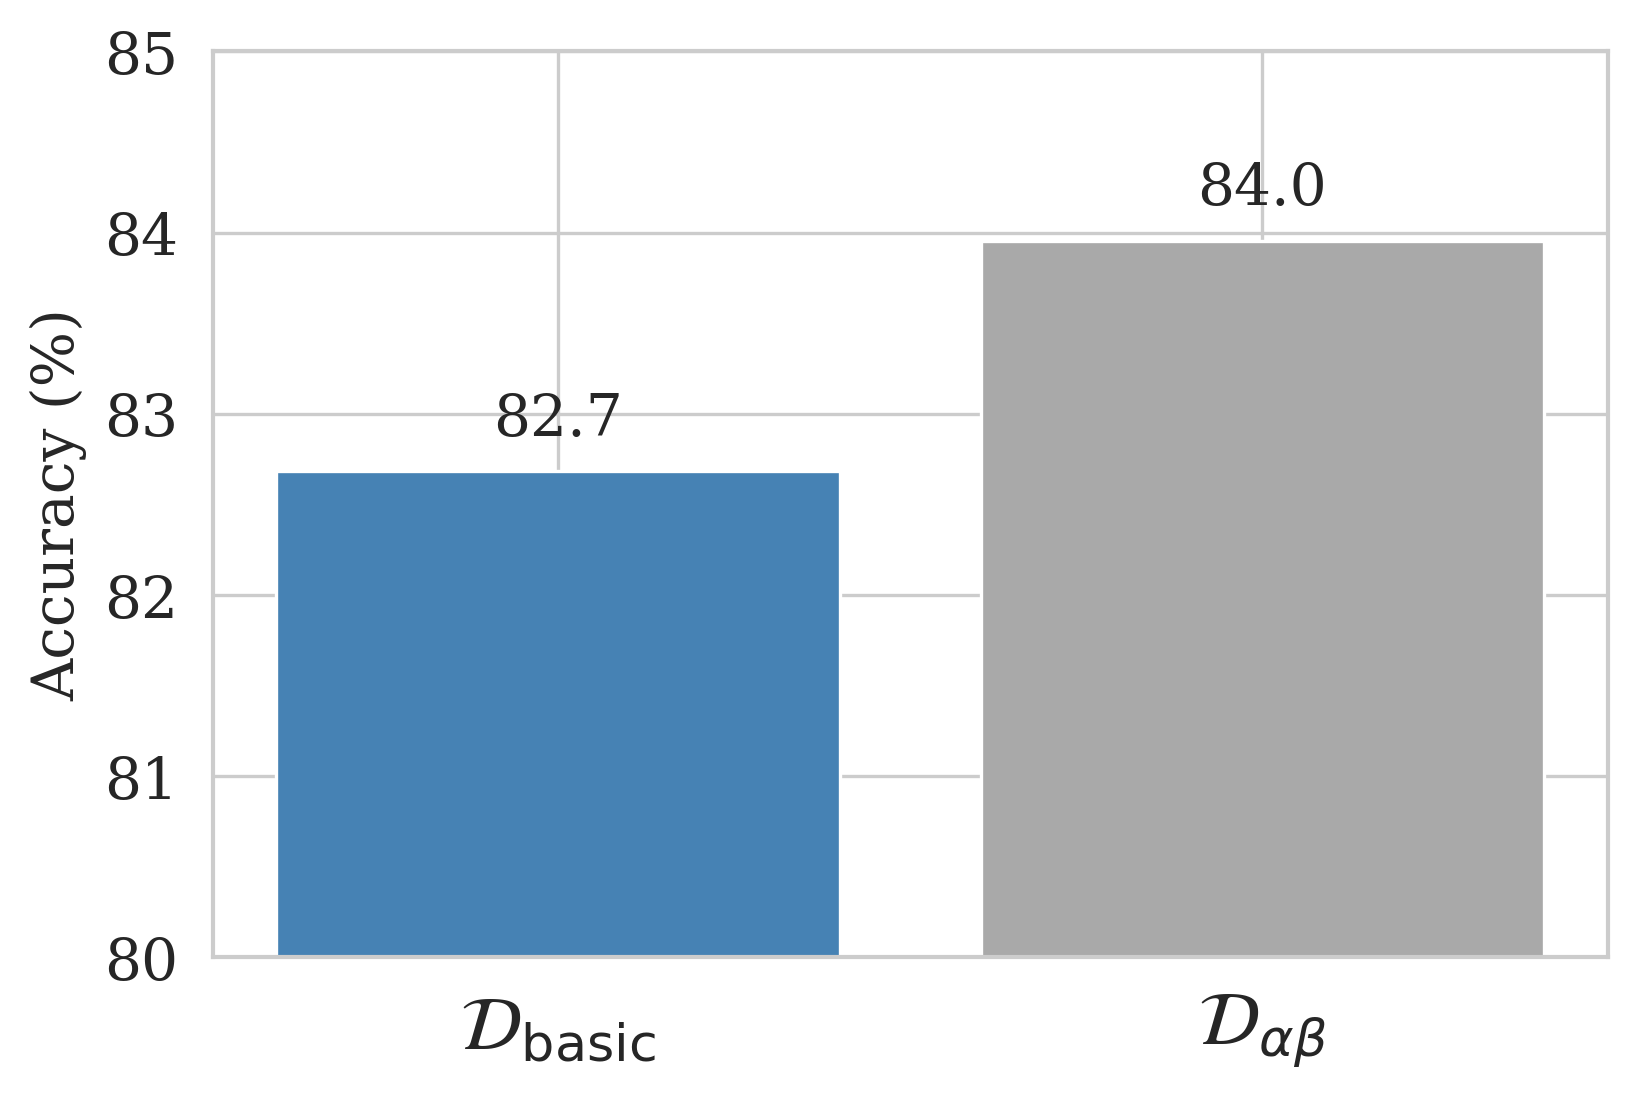

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator  # <-- Import MaxNLocator here
import pandas as pd
from scipy.stats import beta
import seaborn as sns

sns.set(style="whitegrid", context="paper")

rcParams['pdf.use14corefonts'] = True  # Use Type 1 fonts in PDFs
plt.rc('font', family='serif')

# Set plot style for a professional look
fsize = 14

# Print overall statistics
print("Overall Performance:")
print(f"Total Correct Predictions with Subset1 Only: {total_correct['subset']}/{total_samples}")
print(f"Total Correct Predictions with Subset2 Only: {total_correct['subset2']}/{total_samples}")

# Plotting the bar chart of overall performance
plt.figure(dpi=300, facecolor="white")
#plt.rc('text', usetex=False)
#plt.rc('text', usetex=True) # This seems to toggle the font style, unfortunately


labels = [r'$\mathcal{D}_{\mathrm{basic}}$', r'$\mathcal{D}_{\alpha \beta}$']
correct_predictions = [
    total_correct['subset'] / total_samples * 100,
    total_correct['subset2'] / total_samples * 100
]

# Create the bar chart
plt.bar(labels, correct_predictions, color=['steelblue', 'darkgray'], alpha=1)

# Set axis labels and font sizes
plt.ylabel('Accuracy (%)', fontsize=fsize)

# Make y-axis integer only, if desired
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Set tick label font sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=fsize)

# Optional: Limit y-axis if needed
plt.ylim(80, 85)

a_between_no_const = len(results_df[results_df["Improvement (Subset2 vs Subset1) No Const"] > 0])
b_between_no_const = len(results_df[results_df["Improvement (Subset2 vs Subset1) No Const"] < 0])
c_between_no_const = len(results_df[results_df["Improvement (Subset2 vs Subset1) No Const"] == 0])

print("Subset2 vs Subset1 No Const:")
print("Num times Subset2 improved: " + str(a_between_no_const))
print("Num times Subset2 degraded: " + str(b_between_no_const))
print("Num times same: " + str(c_between_no_const))
      
# After creating the bar chart, add these lines:
for i, v in enumerate(correct_predictions):
    plt.text(i, v + 0.2, f'{v:.1f}', 
             horizontalalignment='center',
             fontsize=fsize)

# Save figure
plt.savefig(
    'subset_accuracy_comparison.eps',
    format='eps',
    dpi=300,
    bbox_inches='tight'
)

Mean Accuracy (Subset1 Only): 0.8301371071599483
Mean Accuracy (Subset2 Only): 0.8432924119218427


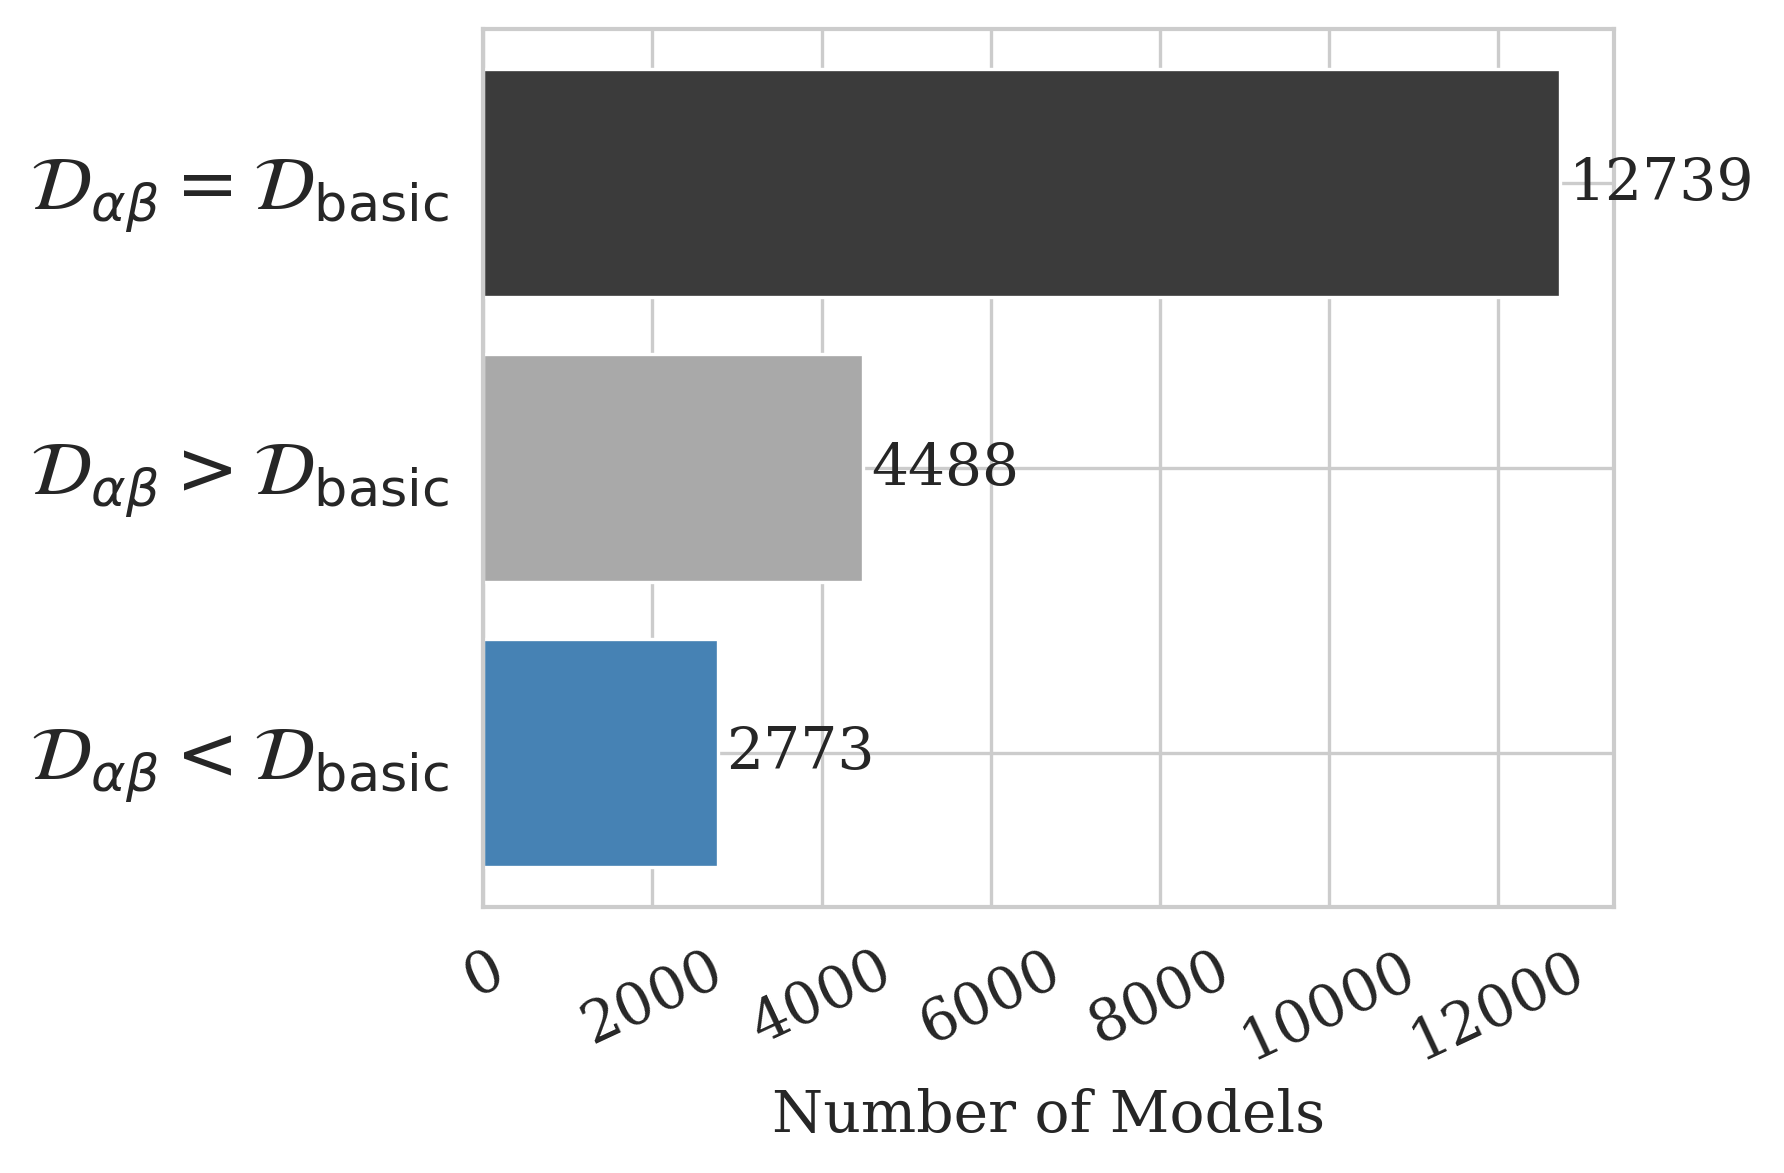

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator  
import pandas as pd
from scipy.stats import beta
import seaborn as sns
import matplotlib
#matplotlib.use('Agg')

sns.set(style="whitegrid", context="paper")

# Use Type 1 fonts in PDFs
rcParams['pdf.use14corefonts'] = True  
plt.rc('font', family='serif')

# Set plot style for a professional look
fsize = 14

df = results_df
total_examples = len(df)

# Print mean accuracies for Subset1 and Subset2
print("Mean Accuracy (Subset1 Only):", df["Accuracy Subset1 Only"].mean())
print("Mean Accuracy (Subset2 Only):", df["Accuracy Subset2 Only"].mean())

# 1) Subset2 vs Subset1: No Const
counts_no_const = {
    r"$\mathcal{D}_{\alpha \beta} = \mathcal{D}_{\mathrm{basic}}$": len(df[df["Improvement (Subset2 vs Subset1) No Const"] == 0]),
    r"$\mathcal{D}_{\alpha \beta} > \mathcal{D}_{\mathrm{basic}}$": len(df[df["Improvement (Subset2 vs Subset1) No Const"] > 0]),
    r"$\mathcal{D}_{\alpha \beta} < \mathcal{D}_{\mathrm{basic}}$": len(df[df["Improvement (Subset2 vs Subset1) No Const"] < 0])
}

# Combine all counts into one dictionary
counts_combined = {**counts_no_const}

categories = list(counts_combined.keys())
values = list(counts_combined.values())

# Define colors for bars
colors = ['#3b3b3b', 'darkgray', 'steelblue'] * len(categories)

# Set up the plot
#plt.rc('text', usetex=True)
plt.figure(dpi=300, facecolor="white")

# Create horizontal bar chart
# Set labels and font sizes
plt.xlabel('Number of Models', fontsize=fsize)

bars = plt.barh(categories, values, color=colors, alpha=1)

plt.xticks(fontsize=fsize, rotation = 25)
plt.yticks(fontsize=18)

# Invert y-axis so the first category is on top
plt.gca().invert_yaxis()

# Add the numbers at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 100,
        (bar.get_y() + bar.get_height() / 2),
        f'{int(width)}',
        va='center',
        ha='left',
        fontsize=fsize
    )

plt.tight_layout()

# Save figure
plt.savefig(
    'alpha_beta_improvement.eps',
    format='eps',
    dpi=300,
    pad_inches=0,  # or 0.1, 0.3, etc.
    bbox_inches='tight'
)

##### Statistical Significance

In [7]:
import math
from scipy.stats import norm

# Given values from the figure and text
total_pairs = 20000
ties = 12739
n_better = 4488
n_worse = 2773

# Check arithmetic consistency
assert n_better + n_worse + ties == total_pairs, "Sum of better, worse, and ties does not match total pairs."

# Effective sample size (excluding ties)
N_prime = n_better + n_worse

# Under H0, p=0.5
p = 0.5
mu = N_prime * p
sigma = math.sqrt(N_prime * p * (1 - p))

# Apply continuity correction for one-sided test: P(X >= n_better)
# Z = (n_better - 0.5 - mu) / sigma
Z = (n_better - 0.5 - mu) / sigma

# Compute p-value from Z-score for one-tailed test
p_value = 1 - norm.cdf(Z)

print("Effective sample size (N'):", N_prime)
print("Observed 'better' count:", n_better)
print("Observed 'worse' count:", n_worse)
print("Mean (mu):", mu)
print("Std dev (sigma):", sigma)
print("Z-score:", Z)
print("p-value:", p_value)

# Confirming if the results are statistically significant:
# For a very large Z like we have, p-value should be extremely small.
if p_value < 1e-100:
    print("The p-value is effectively zero, confirming extremely strong statistical significance.")
else:
    print("The p-value is not as small as expected. Check calculations.")


Effective sample size (N'): 7261
Observed 'better' count: 4488
Observed 'worse' count: 2773
Mean (mu): 3630.5
Std dev (sigma): 42.60575078554537
Z-score: 20.114655514784403
p-value: 0.0
The p-value is effectively zero, confirming extremely strong statistical significance.


#### single `mtry` / `max_features` experiment, regularization

num unique artists - 955
All Artist Combos Length - 909162


,act Pair,Accuracy Subset,Accuracy Subset + Const,Improvement Subset,Number of Test Examples,Number of Train Examples
2815,Collective Soul vs Josiah & The Bonnevilles,0.333333,0.833333,0.500000,6,20
2555,Collective Soul vs Ledisi,0.600000,1.000000,0.400000,5,17
2800,Collective Soul vs Echo & The Bunnymen,0.600000,1.000000,0.400000,5,16
3648,Lee Brice vs Kim Petras,0.500000,0.900000,0.400000,10,39
3518,Lee Brice vs Nicotine Dolls,0.375000,0.750000,0.375000,8,32
...,...,...,...,...,...,...
268,The Avett Brothers vs Macklemore,0.875000,0.500000,-0.375000,8,32
4454,Eric Johnson vs The Paper Kites,0.750000,0.375000,-0.375000,8,32
2656,Collective Soul vs Silversun Pickups,0.750000,0.375000,-0.375000,8,30
629,The Avett Brothers vs The Simon & Garfunkel Story,0.750000,0.375000,-0.375000,8,29


Overall Performance:
Total Correct Predictions with Subset: 42573/52076
Total Correct Predictions with Subset + Constants: 43127/52076


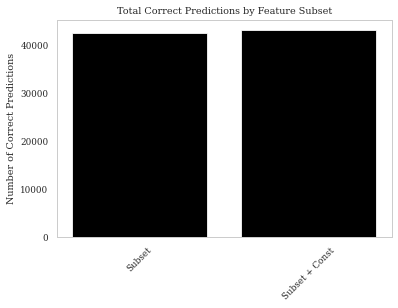

Num improved: 1084
Num degraded: 675
Num same: 3241
0.8170185042608585
0.8276231161711992


In [15]:
data = load_df_from_file()
X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
y_full = data["act"] 

# Define the feature subsets
subset_indices = [0, 1, 2, 3, 4, 5]  

# Create the Cartesian product - this has symmetrical duplicates
# oddly the accuracies arent the same
cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])

# Remove the rows where act1 == act2 to avoid duplicates
df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']]

# Reset the index for df2
df_act_cartesian_product = df_act_cartesian_product.reset_index(drop=True)
print(f"All Artist Combos Length - {len(df_act_cartesian_product)}")

act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]

# Feature names for subsets
feature_names_full = X_full.columns
feature_names_subset1 = feature_names_full[subset_indices]

# Initialize cumulative feature usage counts
total_feature_usage_subset1 = np.zeros(len(subset_indices))
total_feature_usage_subset1_const = np.zeros(len(subset_indices))

# To store results for each pairwise model
results = []

# Initialize counters for total correct predictions
total_correct = {
    'subset': 0,
    'subset_const': 0,
}
total_samples = 0

break_after = 5000
num_iter = 0

all_models = []
all_models_regularization = []

columns_to_correlate = ['average_price', 'median_price', 'lowest_price', 
                        'highest_price', 'alpha', 'beta']
all_correlations = []

# Iterate over each pair of acts
for act_1, act_2 in act_pairs:
    
    # Filter data for the current pair of acts
    pair_mask = (y_full == act_1) | (y_full == act_2)
     
    
    X_pair_full = X_full[pair_mask]
    y_pair = y_full[pair_mask].replace({act_1: 0, act_2: 1})  # Binary labels
    
    # Split the data
    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X_pair_full, y_pair, test_size=0.2, random_state=42
    )
    
    # collect the correlations for the features to the target for each pair dataset
    # ie for each model
    correlations = {col: abs(X_train_full[col].corr(y_train)) for col in columns_to_correlate}
    all_correlations.append(correlations)
    
    # Keep track of total samples
    total_samples += len(y_test)

    # Function to train and evaluate model on a given subset of features
    def train_evaluate_model(X_train, X_test, feature_subset, add_constants=False):
        # Select the subset of features
        X_train_subset = X_train.iloc[:, feature_subset].copy()
        X_test_subset = X_test.iloc[:, feature_subset].copy()
        
        if add_constants:
            # Add 20 constant features with the same value (e.g., zero)
            num_constants = 20
            const_value = 0  # or any constant value
            for i in range(num_constants):
                X_train_subset[f'const_{i}'] = const_value
                X_test_subset[f'const_{i}'] = const_value
        
        # Train the model
        model = RandomForestClassifier(random_state=42, 
                                          class_weight='balanced', 
                                          max_features=6,
                                          max_depth=100,
                                          n_estimators=100)
        model.fit(X_train_subset, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        correct_predictions = np.sum(y_pred == y_test)
        
        return accuracy, correct_predictions, model

    # Train and evaluate models
    # Subset without constants
    acc, correct, model = train_evaluate_model(X_train_full, X_test_full, subset_indices, add_constants=False)
    total_correct['subset'] += correct
    all_models.append(model)

    # Subset with constants
    acc_const, correct_const, model_reg = train_evaluate_model(X_train_full, X_test_full, 
                                                               subset_indices, add_constants=True)
    total_correct['subset_const'] += correct_const
    all_models_regularization.append(model_reg)

    # Improvement for Subset
    improvement = acc_const - acc

    # Store the results
    results.append({
        "act Pair": f"{act_1} vs {act_2}",
        "Accuracy Subset": acc,
        "Accuracy Subset + Const": acc_const,
        "Improvement Subset": improvement,
        "Number of Test Examples": len(X_test_full),
        "Number of Train Examples": len(X_train_full)
    })
    
        # Collect feature usage counts
    def collect_feature_usage(model, num_original_features):
        # Initialize feature usage counts
        feature_usage = np.zeros(num_original_features)
        
        # Iterate through each tree in the Random Forest model
        for tree in model.estimators_:
            tree_features = tree.tree_.feature
            for feature_used in tree_features:
                if feature_used >= 0 and feature_used < num_original_features:
                    feature_usage[feature_used] += 1
        return feature_usage

    # For Subset 1 without constants
    num_features_subset1 = len(subset_indices)
    model_subset1 = model
    feature_usage_subset1 = collect_feature_usage(model_subset1, num_features_subset1)
    total_feature_usage_subset1 += feature_usage_subset1

    # For Subset 1 with constants
    model_subset1_const = model_reg
    feature_usage_subset1_const = collect_feature_usage(model_subset1_const, num_features_subset1)
    total_feature_usage_subset1_const += feature_usage_subset1_const

    num_iter += 1
    if num_iter >= break_after:
        break

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Improvement Subset', ascending=False)
display(results_df)
results_df.to_csv("results_df_4_28_2024_regularization.csv", index=False)

# Print overall statistics
print("Overall Performance:")
print(f"Total Correct Predictions with Subset: {total_correct['subset']}/{total_samples}")
print(f"Total Correct Predictions with Subset + Constants: {total_correct['subset_const']}/{total_samples}")

# Plotting the bar chart of overall performance
labels = ['Subset', 'Subset + Const']
correct_predictions = [
    total_correct['subset'],
    total_correct['subset_const'],
]

plt.bar(labels, correct_predictions, color=['black', 'black'])
plt.title('Total Correct Predictions by Feature Subset')
plt.ylabel('Number of Correct Predictions')
plt.xticks(rotation=45)
plt.grid()
plt.show()

a = len(results_df[results_df["Improvement Subset"] > 0])
b = len(results_df[results_df["Improvement Subset"] < 0])
c = len(results_df[results_df["Improvement Subset"] == 0])
print("Num improved: " + str(a))
print("Num degraded: " + str(b))
print("Num same: " + str(c))
      
print(results_df["Accuracy Subset"].mean())
print(results_df["Accuracy Subset + Const"].mean())

In [16]:
# Extract unique acts from the "act Pair" column
unique_acts = set()
results_df['act Pair'].str.split(' vs ').apply(unique_acts.update)
print("Unique Acts - " + str(len(unique_acts)))

print("Average Number of Testing and Training Examples")
print(results_df['Number of Test Examples'].mean())
print(results_df['Number of Train Examples'].mean())

Unique Acts - 954
Average Number of Testing and Training Examples
10.4152
39.6448


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


['$\\mu_i$', '$\\tilde{\\mu}_i$', '$\\mathrm{Min}_i$', '$\\mathrm{Max}_i$', '$\\alpha_i$', '$\\beta_i$']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


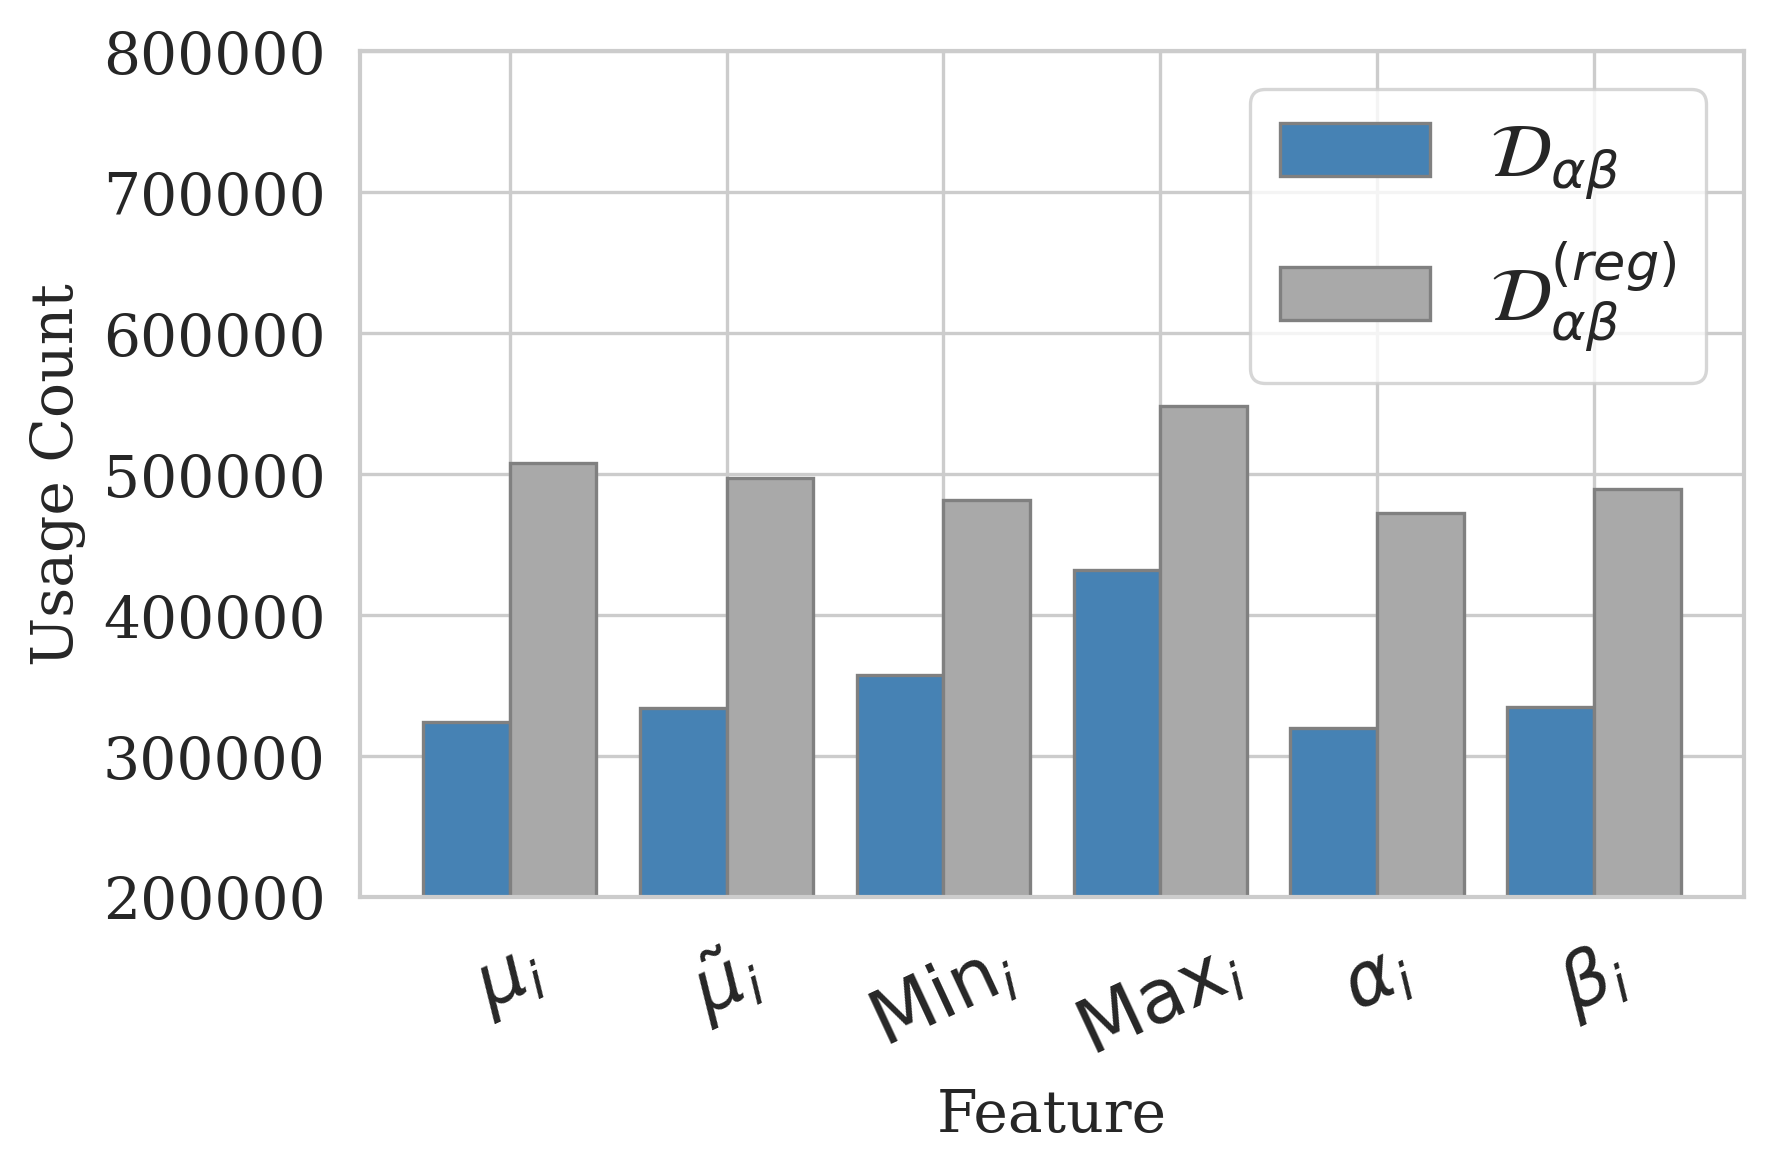

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

# Set a professional plot style with seaborn
fsize = 14  # Base font size for labels and ticks

# --- Data for plotting ---
#   feature_names_subset1: list of feature names (strings)
#   total_feature_usage_subset1: usage counts without regularization (list or array)
#   total_feature_usage_subset1_const: usage counts with regularization (list or array)
indices1 = np.arange(len(feature_names_subset1))
subs1 = total_feature_usage_subset1
subs2 = total_feature_usage_subset1_const
fns1 = feature_names_subset1

# Create figure with high DPI and a white background
#plt.figure(figsize=(12, 8), dpi=300, facecolor='white')
plt.figure(dpi=300, facecolor="white")
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering

escaped_strings = []
for s in fns1:
    s = s.replace("average_price", r'$\mu_i$')
    s = s.replace("median_price", r"$\tilde{\mu}_i$")
    s = s.replace("lowest_price", r"$\mathrm{Min}_i$")
    s = s.replace("highest_price", r"$\mathrm{Max}_i$")
    s = s.replace("beta", r"$\beta_i$")
    s = s.replace("alpha", r"$\alpha_i$")
    escaped_strings.append(s)
    
fns1 = escaped_strings
print(fns1)

# Plot the bar charts for feature usage counts
plt.bar(indices1 - 0.2, subs1, width=0.4, label=r'$\mathcal{D}_{\alpha \beta}$',
        color='steelblue', edgecolor='gray', alpha=1)
plt.bar(indices1 + 0.2, subs2, width=0.4, label=r'$\mathcal{D}_{\alpha \beta}^{(reg)}$',
        color='darkgray', edgecolor='gray', alpha=1)

# Label axes using LaTeX formatting and the defined font size
plt.xlabel(r'Feature', fontsize=fsize)
plt.ylabel(r'Usage Count', fontsize=fsize)

# Set x-ticks to show feature names, rotated for clarity
plt.xticks(indices1, fns1, rotation=25, fontsize=18)
plt.yticks(fontsize=fsize)

plt.ylim(200000,800000)

# Position the legend outside the main plot area
plt.legend(loc='upper right',  prop={'family': 'serif', 'size': 18})

# Adjust layout to minimize whitespace
plt.tight_layout()

# Save the figure in both EPS and PNG formats with high resolution
plt.savefig(
    'regularization_feature_usage_tickets.eps',
    format='eps',
    dpi=300,
    pad_inches=.1,
    bbox_inches='tight'
)

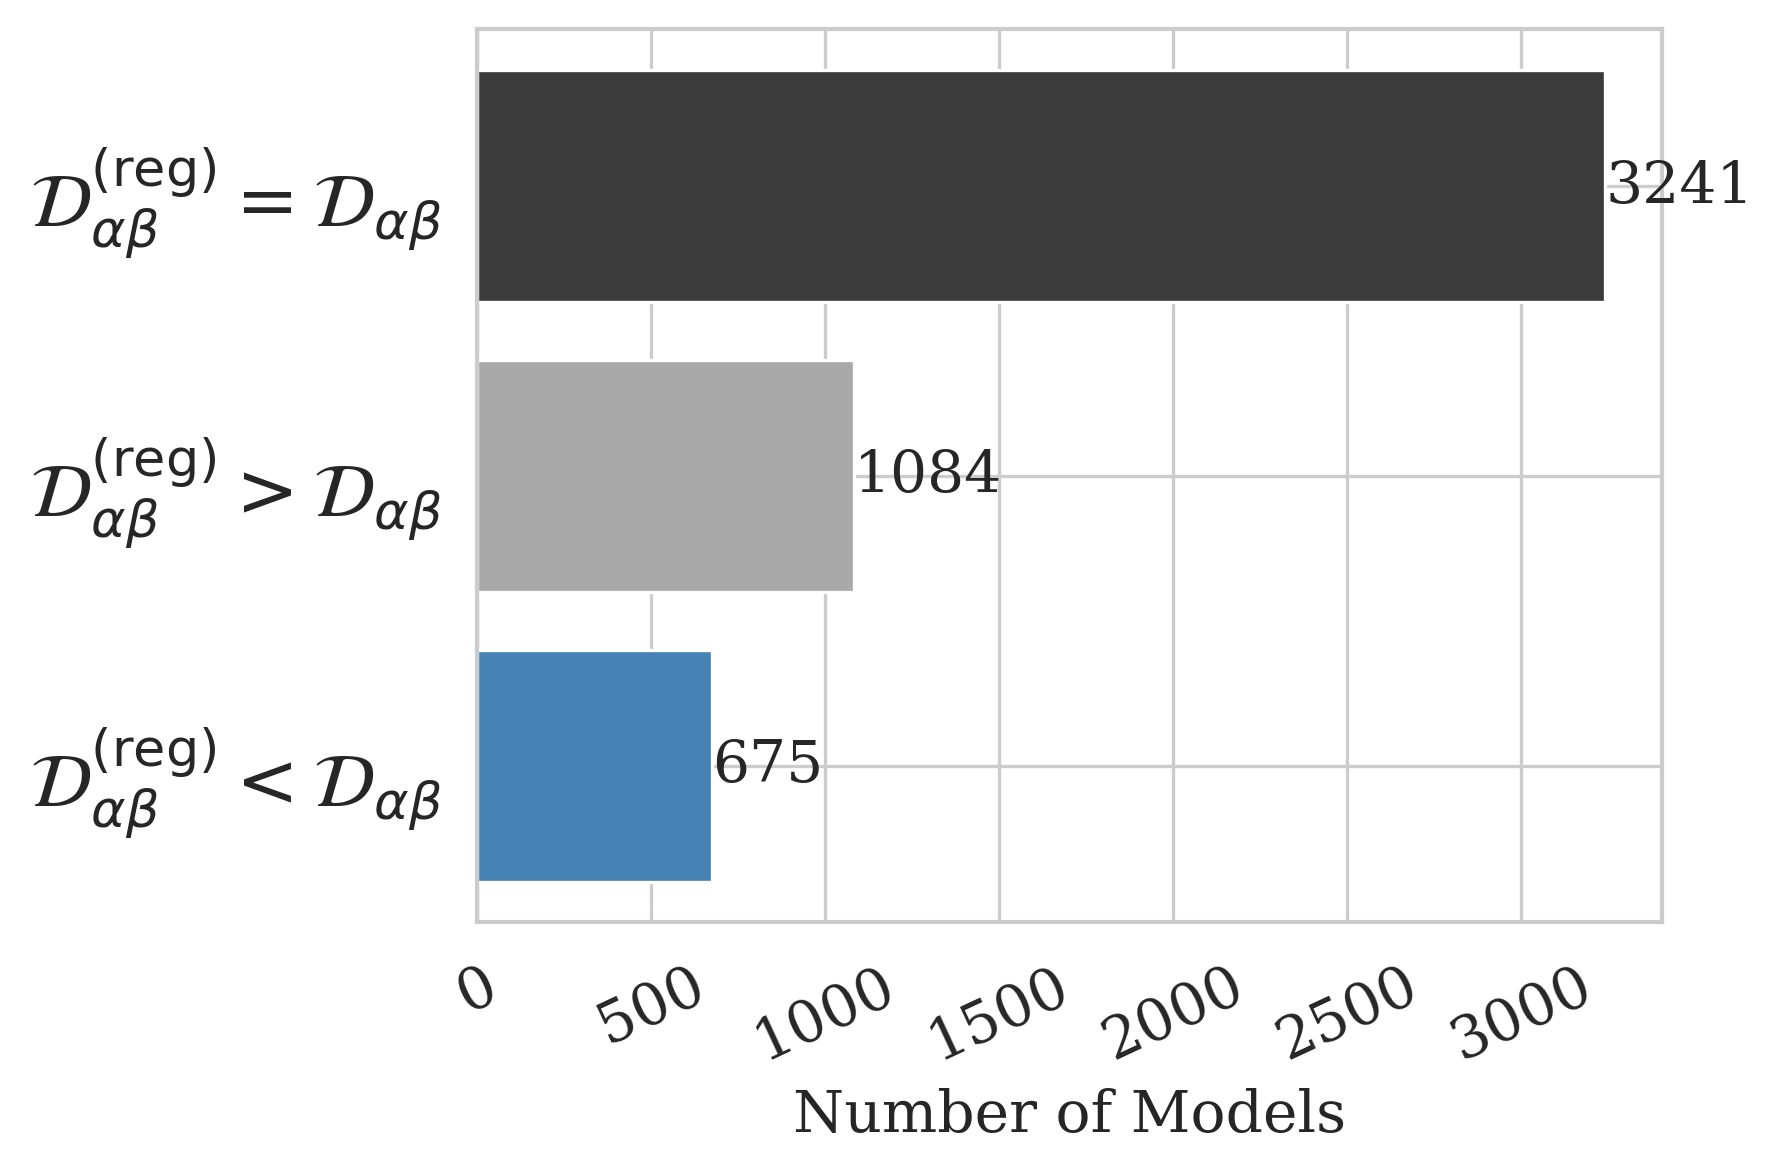

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator 
import pandas as pd
from scipy.stats import beta
import seaborn as sns

import matplotlib
#matplotlib.use('Agg')

sns.set(style="whitegrid", context="paper")

# Use Type 1 fonts in PDFs
rcParams['pdf.use14corefonts'] = True  
plt.rc('font', family='serif')

# Set plot style for a professional look
fsize = 14

df = results_df
total_examples = len(df)

# Print mean accuracies for all four accuracy columns
# print("Mean Accuracy (Subset1 Only):", df["Accuracy Subset1 Only"].mean())
# print("Mean Accuracy (Subset2 Only):", df["Accuracy Subset2 Only"].mean())

# 1) Subset2 vs Subset1: No Const
counts_no_const = {
    r"$\mathcal{D}_{\alpha \beta}^{(\mathrm{reg})} = \mathcal{D}_{\alpha \beta}$": len(df[df["Improvement Subset"] == 0]),
    r"$\mathcal{D}_{\alpha \beta}^{(\mathrm{reg})} > \mathcal{D}_{\alpha \beta}$": len(df[df["Improvement Subset"] > 0]),
    r"$\mathcal{D}_{\alpha \beta}^{(\mathrm{reg})} < \mathcal{D}_{\alpha \beta}$": len(df[df["Improvement Subset"] < 0])
}

# Combine all counts into one dictionary
counts_combined = {**counts_no_const}

categories = list(counts_combined.keys())
values = list(counts_combined.values())
colors = ['#3b3b3b', 'darkgray', 'steelblue'] * len(categories)

#plt.figure(figsize=(8, 6), facecolor="white")  # Set background to white

plt.figure(dpi=300, facecolor="white")
#plt.rc('text', usetex=True)
bars = plt.barh(categories, values, color=colors)
plt.xlabel('Number of Models', fontsize=fsize)
#plt.xlim(0, 5000)
#plt.ylabel('Comparisons')
#plt.title(r'Performance Comparisons of Random Forest Models ($N_{models} = 5000$)')

plt.xticks(fontsize=fsize, rotation = 25)
plt.yticks(fontsize=18)

plt.gca().invert_yaxis()  # Invert y-axis so the first category is on top
#plt.grid()

# Adding the numbers at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', ha='left', fontsize=fsize)

#plt.show()
#plt.tight_layout()
#plt.savefig("regularization_improvement_tickets.png", format="png", dpi=150, bbox_inches='tight')  # Adjust dpi for resolution

plt.tight_layout()

# Save figure
plt.savefig(
    'regularization_improvement_tickets.eps',
    format='eps',
    dpi=300,
    pad_inches=.1,  # or 0.1, 0.3, etc.
    bbox_inches='tight'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


All Models Median Depth: 3.0
All Models Average Depth: 3.18055
Regularized Models Median Depth: 4.0
Regularized Models Average Depth: 4.156848


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


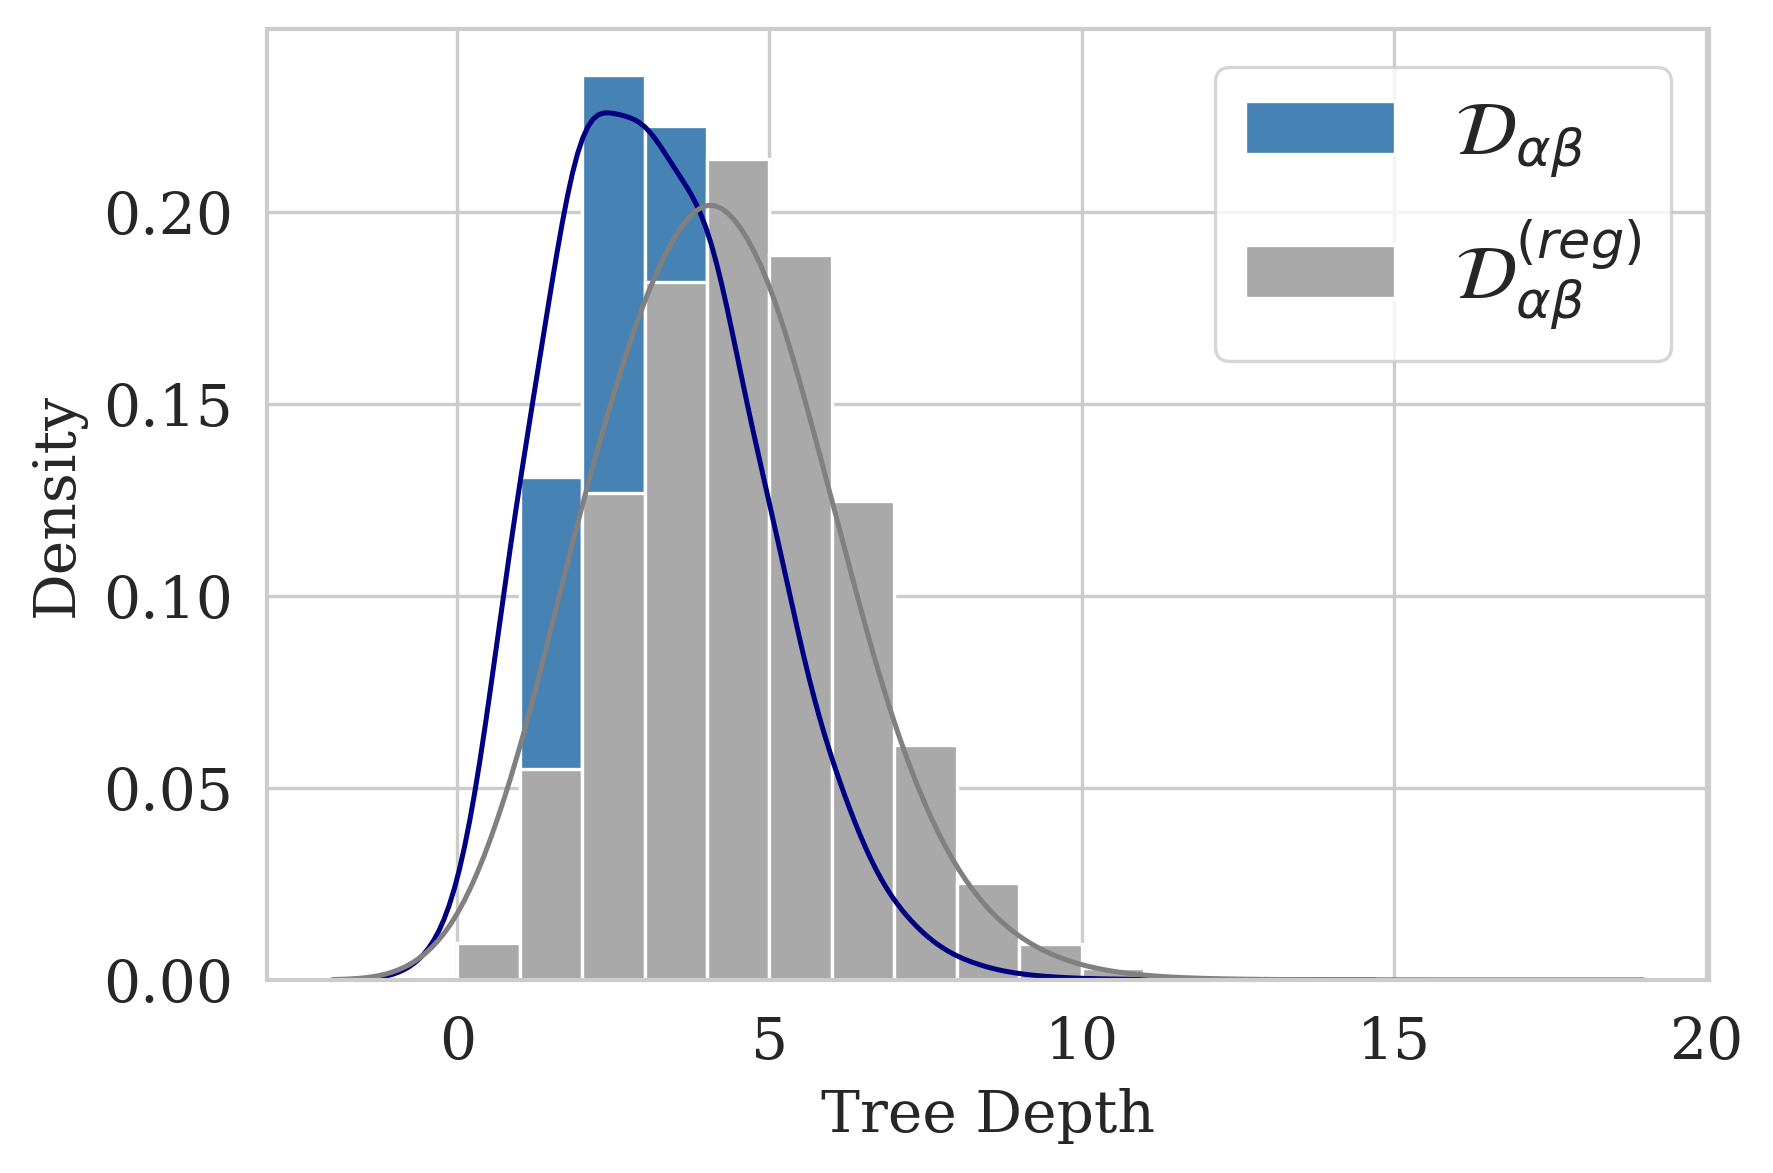

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rc('font', family='serif')

# Set a professional plot style with seaborn
#sns.set(style="whitegrid", context="paper")
fsize = 14  # Base font size for labels and ticks

# Gather all tree depths for the first set of models
all_depths = []
for model in all_models:
    for estimator in model.estimators_:
        all_depths.append(estimator.tree_.max_depth)

# Gather all tree depths for the second set of models
all_depths_reg = []
for model in all_models_regularization:
    for estimator in model.estimators_:
        all_depths_reg.append(estimator.tree_.max_depth)

# Create a single figure
plt.figure(dpi=300, facecolor="white")
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#sns.set_style("whitegrid")

# Plot histogram and KDE for all_models
sns.histplot(
    all_depths,
    kde=False,
    color='steelblue',
    binwidth=1,
    stat='density',
    label=r'$\mathcal{D}_{\alpha \beta}$',
    alpha=1
)
sns.kdeplot(
    all_depths,
    color='navy',
    bw_adjust=5,
)

# Plot histogram and KDE for all_models_regularization
sns.histplot(
    all_depths_reg,
    kde=False,
    color='darkgray',
    binwidth=1,
    stat='density',
    label=r'$\mathcal{D}_{\alpha \beta}^{(reg)}$',
    alpha=1
)
sns.kdeplot(
    all_depths_reg,
    color='gray',
    bw_adjust=5,
)

# Add labels
plt.xlabel("Tree Depth", fontsize=fsize)
plt.ylabel("Density", fontsize=fsize)
plt.legend(fontsize=18)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.tight_layout()

# Print statistics
print("All Models Median Depth:", np.median(all_depths))
print("All Models Average Depth:", np.mean(all_depths))

print("Regularized Models Median Depth:", np.median(all_depths_reg))
print("Regularized Models Average Depth:", np.mean(all_depths_reg))

# Save the figure in both EPS and PNG formats with high resolution
plt.savefig(
    'regularization_tree_depth_tickets.eps',
    format='eps',
    dpi=300,
    pad_inches=.1,
    bbox_inches='tight'
)

##### Distribution of Tree Variety in RF Ensembles (from the Paper)

Let the model $m$ be composed of $n$ trees. For each tree $i \in \{1, 2, \ldots, n\}$, we have a count vector of features $\mathbf{v}_i \in \mathbb{R}^d$, where $d$ is the number of features. Each entry $v_{i,k}$ in the vector $\mathbf{v}_i$ represents how many times feature $k$ was used in tree $i$.

The Euclidean distance between two trees $i$ and $j$ is given by:

$$
\text{distance}(\mathbf{v}_i, \mathbf{v}_j) = || \mathbf{v}_i - \mathbf{v}_j ||_2 = \sqrt{\sum_{k=1}^{d} (v_{i,k} - v_{j,k})^2}.
$$

To quantify the total variety within model $m$, we sum the pairwise distances over all unique pairs of distinct trees:

$$
V(m) = \sum_{1 \leq i < j \leq n} || \mathbf{v}_i - \mathbf{v}_j ||_2.
$$

In other words, $V(m)$ is the sum of the Euclidean distances between every pair of trees' feature count vectors within the model. This value captures how diverse or varied the trees are with respect to their usage of features.

When we have multiple models (e.g., a list of models $\{m_1, m_2, \ldots, m_M\}$), each with a calculated variety measure $V(m_i)$ as described previously, we can consider these variety values across all models as forming a distribution. Concretely, if each model $m_i$ consists of $n_i$ trees, we compute the total variety:

$$
V(m_i) = \sum_{1 \leq p < q \leq n_i} \| \mathbf{v}_p - \mathbf{v}_q \|_2,
$$

where $\mathbf{v}_p$ and $\mathbf{v}_q$ are the feature usage vectors for the $p$-th and $q$-th trees in model $m_i$.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.stats import skew, kurtosis
from matplotlib import rcParams

def get_tree_feature_counts(rf_model):
    """
    Extracts a count vector for each tree that indicates how many times each feature 
    was used as a splitting feature in that tree.
    """
    n_features = rf_model.n_features_in_
    tree_feature_counts = []
    for estimator in rf_model.estimators_:
        feature_usage = estimator.tree_.feature
        counts = np.bincount(feature_usage[feature_usage >= 0], minlength=n_features)
        tree_feature_counts.append(counts)
    return np.array(tree_feature_counts)

def compute_pairwise_distances(tree_feature_counts):
    """
    Computes the pairwise Euclidean distances between all trees in the forest.
    Returns a flattened array of distances (excluding diagonal).
    """
    distances = pdist(tree_feature_counts, metric='euclidean')
    return distances

def aggregate_model_distances(models):
    """
    Compute aggregated pairwise distances for each model in a list of models.
    Returns a list of arrays, where each array contains all pairwise distances for a model.
    """
    all_distances = []
    for m in models:
        tree_counts = get_tree_feature_counts(m)
        dist = compute_pairwise_distances(tree_counts)
        all_distances.append(dist)
    return all_distances

# Compute distances for both sets
all_distances_no_reg = aggregate_model_distances(all_models)
all_distances_reg = aggregate_model_distances(all_models_regularization)

# Flatten all distances across models
flat_no_reg_distances = np.concatenate(all_distances_no_reg)
flat_reg_distances = np.concatenate(all_distances_reg)

# Compute summary statistics
def print_distribution_stats(name, data):
    m_mean = np.mean(data)
    m_median = np.median(data)
    m_var = np.var(data, ddof=1)
    m_std = np.std(data, ddof=1)
    m_skew = skew(data)
    m_kurt = kurtosis(data, fisher=True)
    
    print(f"{name}:")
    print(f"  Mean:      {m_mean:.4f}")
    print(f"  Median:    {m_median:.4f}")
    print(f"  Variance:  {m_var:.4f}")
    print(f"  Std Dev:   {m_std:.4f}")
    print(f"  Skewness:  {m_skew:.4f}")
    print(f"  Kurtosis:  {m_kurt:.4f}")
    print()

print_distribution_stats("No Regularization Models", flat_no_reg_distances)
print_distribution_stats("Regularization Models", flat_reg_distances)



No Regularization Models:
  Mean:      2.2603
  Median:    2.0000
  Variance:  1.3981
  Std Dev:   1.1824
  Skewness:  0.5463
  Kurtosis:  0.7633

Regularization Models:
  Mean:      2.9914
  Median:    2.8284
  Variance:  1.6064
  Std Dev:   1.2674
  Skewness:  0.6369
  Kurtosis:  0.8843



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


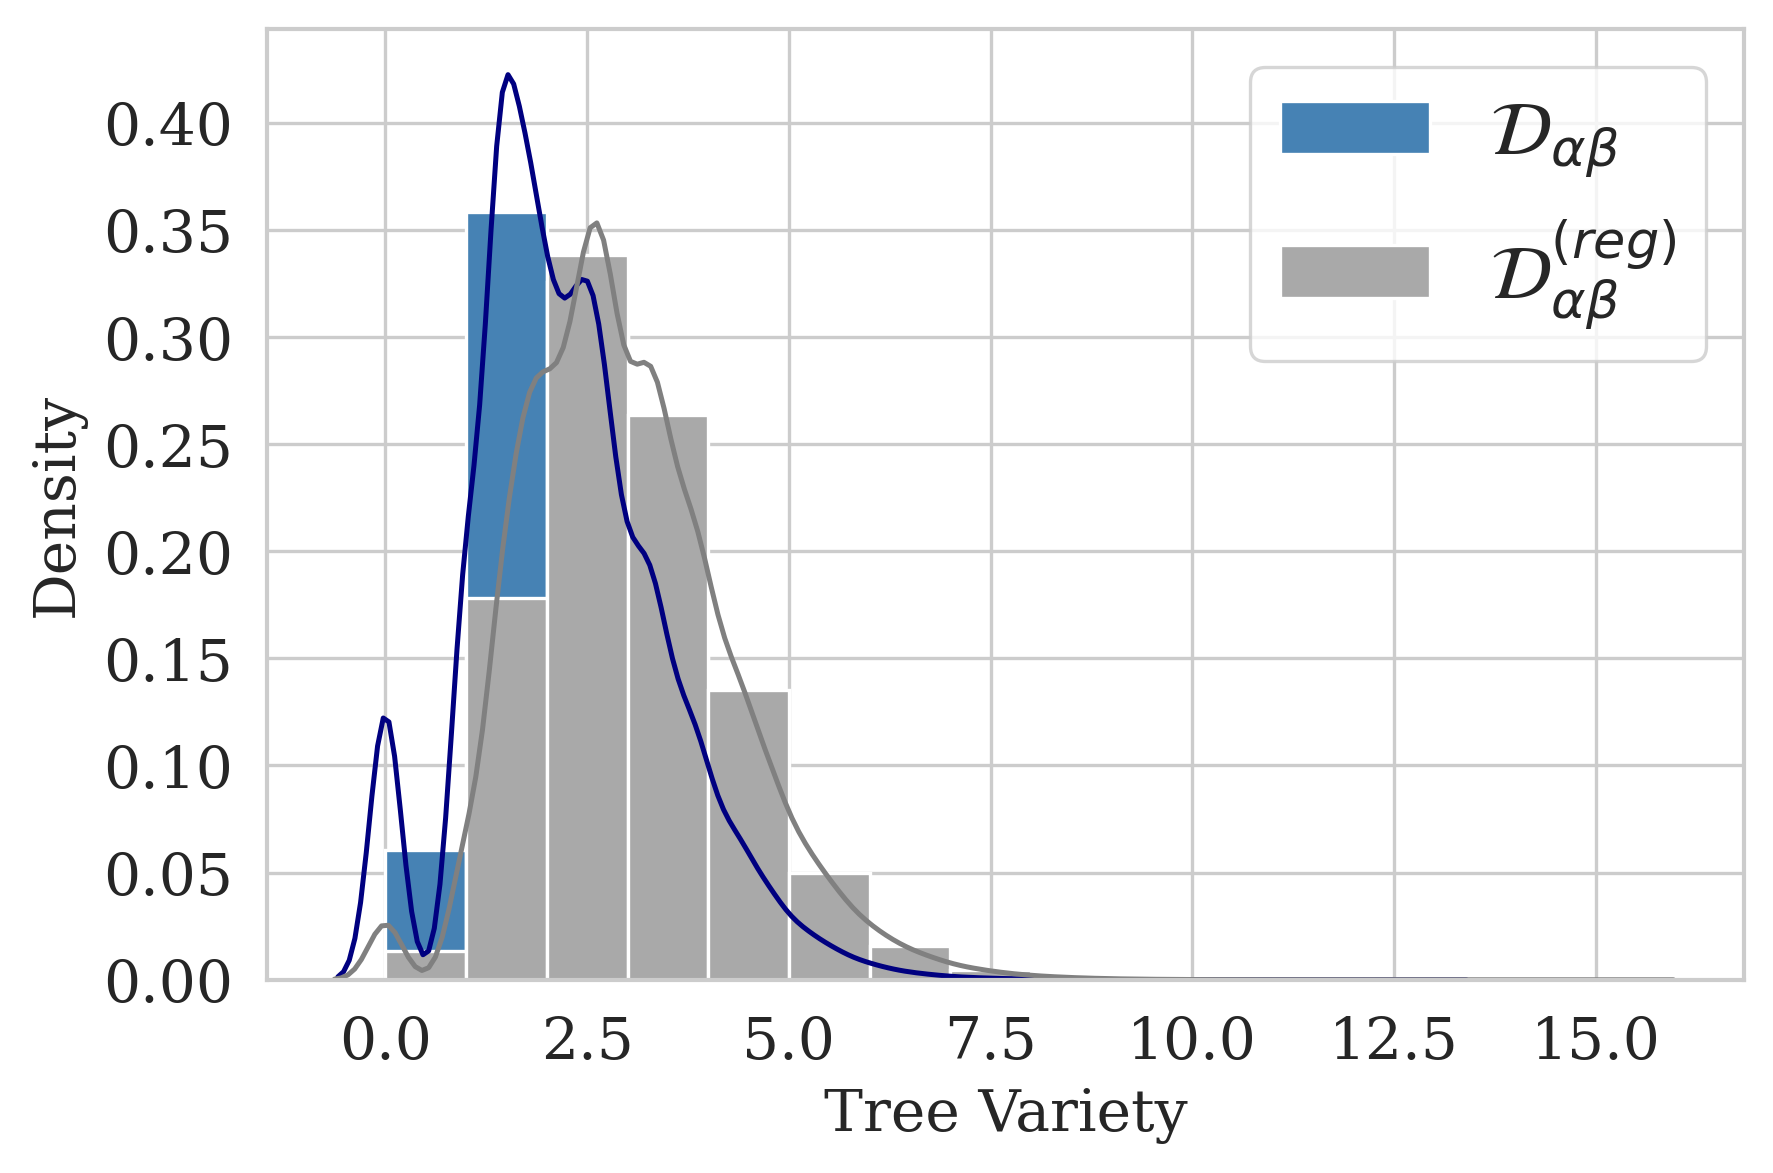

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rc('font', family='serif')

# Set a professional plot style with seaborn
#sns.set(style="whitegrid", context="paper")
fsize = 14  # Base font size for labels and ticks

# Create a single figure
plt.figure(dpi=300, facecolor="white")
#sns.set_style("whitegrid")

# Plot histogram & KDE for No Regularization
sns.histplot(
    flat_no_reg_distances, 
    kde=False, 
    color='steelblue', 
    binwidth=1,
    stat='density', 
    label=r'$\mathcal{D}_{\alpha \beta}$', 
    alpha=1
)
sns.kdeplot(
    flat_no_reg_distances, 
    color='navy', 
    bw_adjust=5,
)

# Plot histogram & KDE for With Regularization
sns.histplot(
    flat_reg_distances, 
    kde=False, 
    color='darkgray', 
    binwidth=1,
    stat='density', 
    label=r'$\mathcal{D}_{\alpha \beta}^{(reg)}$', 
    alpha=1
)
sns.kdeplot(
    flat_reg_distances, 
    color='gray', 
    bw_adjust=5,
)

# Add labels and formatting
plt.xlabel("Tree Variety", fontsize=fsize)
plt.ylabel("Density", fontsize=fsize)
plt.legend(fontsize=18)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.tight_layout()

# Save the figure in both EPS and PNG formats with high resolution
plt.savefig(
    'regularization_tree_distance_tickets.eps',
    format='eps',
    dpi=300,
    pad_inches=.1,
    bbox_inches='tight'
)

#### iterate all `max_features`, regularization

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the data
data = load_df_from_file()

X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
y_full = data["act"]

# Define the feature subsets
subset_indices = [0, 1, 2, 3, 4, 5]
num_features = len(subset_indices)

# Create the Cartesian product of acts
cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])
df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']].reset_index(drop=True)
act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]

# We'll break after a certain number of iterations for performance reasons
break_after = 5000

# Function to train and evaluate the model
def train_evaluate_model(X_train, X_test, y_train, y_test, feature_subset, add_constants, max_features):
    X_train_subset = X_train.iloc[:, feature_subset].copy()
    X_test_subset = X_test.iloc[:, feature_subset].copy()

    if add_constants:
        # Add 20 constant features
        num_constants = 20
        const_value = 0
        for i in range(num_constants):
            X_train_subset[f'const_{i}'] = const_value
            X_test_subset[f'const_{i}'] = const_value

    model = RandomForestClassifier(random_state=42, 
                                   class_weight='balanced', 
                                   max_features=max_features,
                                   max_depth=100,
                                   n_estimators=100)
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# For each max_features from 1 to number of subset features, we will compute average accuracy
accuracy_no_const = []
accuracy_const = []

for mf in range(1, num_features + 1):
    acc_no_const_list = []
    acc_const_list = []
    num_iter = 0
    
    for act_1, act_2 in act_pairs:
        # Filter data for the current pair of acts
        pair_mask = (y_full == act_1) | (y_full == act_2)
        X_pair_full = X_full[pair_mask]
        y_pair = y_full[pair_mask].replace({act_1: 0, act_2: 1})
        
        # If there's not enough data to split, skip
        if len(y_pair) < 2:
            continue

        X_train_full, X_test_full, y_train, y_test = train_test_split(
            X_pair_full, y_pair, test_size=0.2, random_state=42
        )

        # Skip if train or test is empty
        if X_train_full.empty or X_test_full.empty:
            continue

        # Accuracy without constants
        acc_no_const_cur = train_evaluate_model(
            X_train_full, X_test_full, y_train, y_test, subset_indices, add_constants=False, max_features=mf
        )
        acc_no_const_list.append(acc_no_const_cur)

        # Accuracy with constants
        acc_const_cur = train_evaluate_model(
            X_train_full, X_test_full, y_train, y_test, subset_indices, add_constants=True, max_features=mf
        )
        acc_const_list.append(acc_const_cur)

        num_iter += 1
        if num_iter >= break_after:
            break
    
    # Average accuracy over the evaluated pairs
    if acc_no_const_list:
        accuracy_no_const.append(np.mean(acc_no_const_list))
    else:
        accuracy_no_const.append(np.nan)

    if acc_const_list:
        accuracy_const.append(np.mean(acc_const_list))
    else:
        accuracy_const.append(np.nan)


In [10]:
# The code above creates these but is very slow
import pickle
import json

# with open("accuracy_no_const_2.json", "w") as file:
#     json.dump(accuracy_no_const, file)
    
# with open("accuracy_const_2.json", "w") as file:
#     json.dump(accuracy_const, file)

# Load the data
data = load_df_from_file()

X_full = data[["average_price", "median_price", "lowest_price", "highest_price", "alpha", "beta"]]
y_full = data["act"]

# Define the feature subsets
subset_indices = [0, 1, 2, 3, 4, 5]
num_features = len(subset_indices)

# Create the Cartesian product of acts
cartesian_product = pd.DataFrame(list(product(data['act'].unique(), repeat=2)), columns=['act1', 'act2'])
df_act_cartesian_product = cartesian_product[cartesian_product['act1'] != cartesian_product['act2']].reset_index(drop=True)
act_pairs = [(row.act1, row.act2) for row in df_act_cartesian_product.itertuples()]

    
with open("accuracy_no_const_2.json", "r") as file:
    accuracy_no_const = json.load(file)
    
with open("accuracy_const_2.json", "r") as file:
    accuracy_const = json.load(file)

num unique artists - 955


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


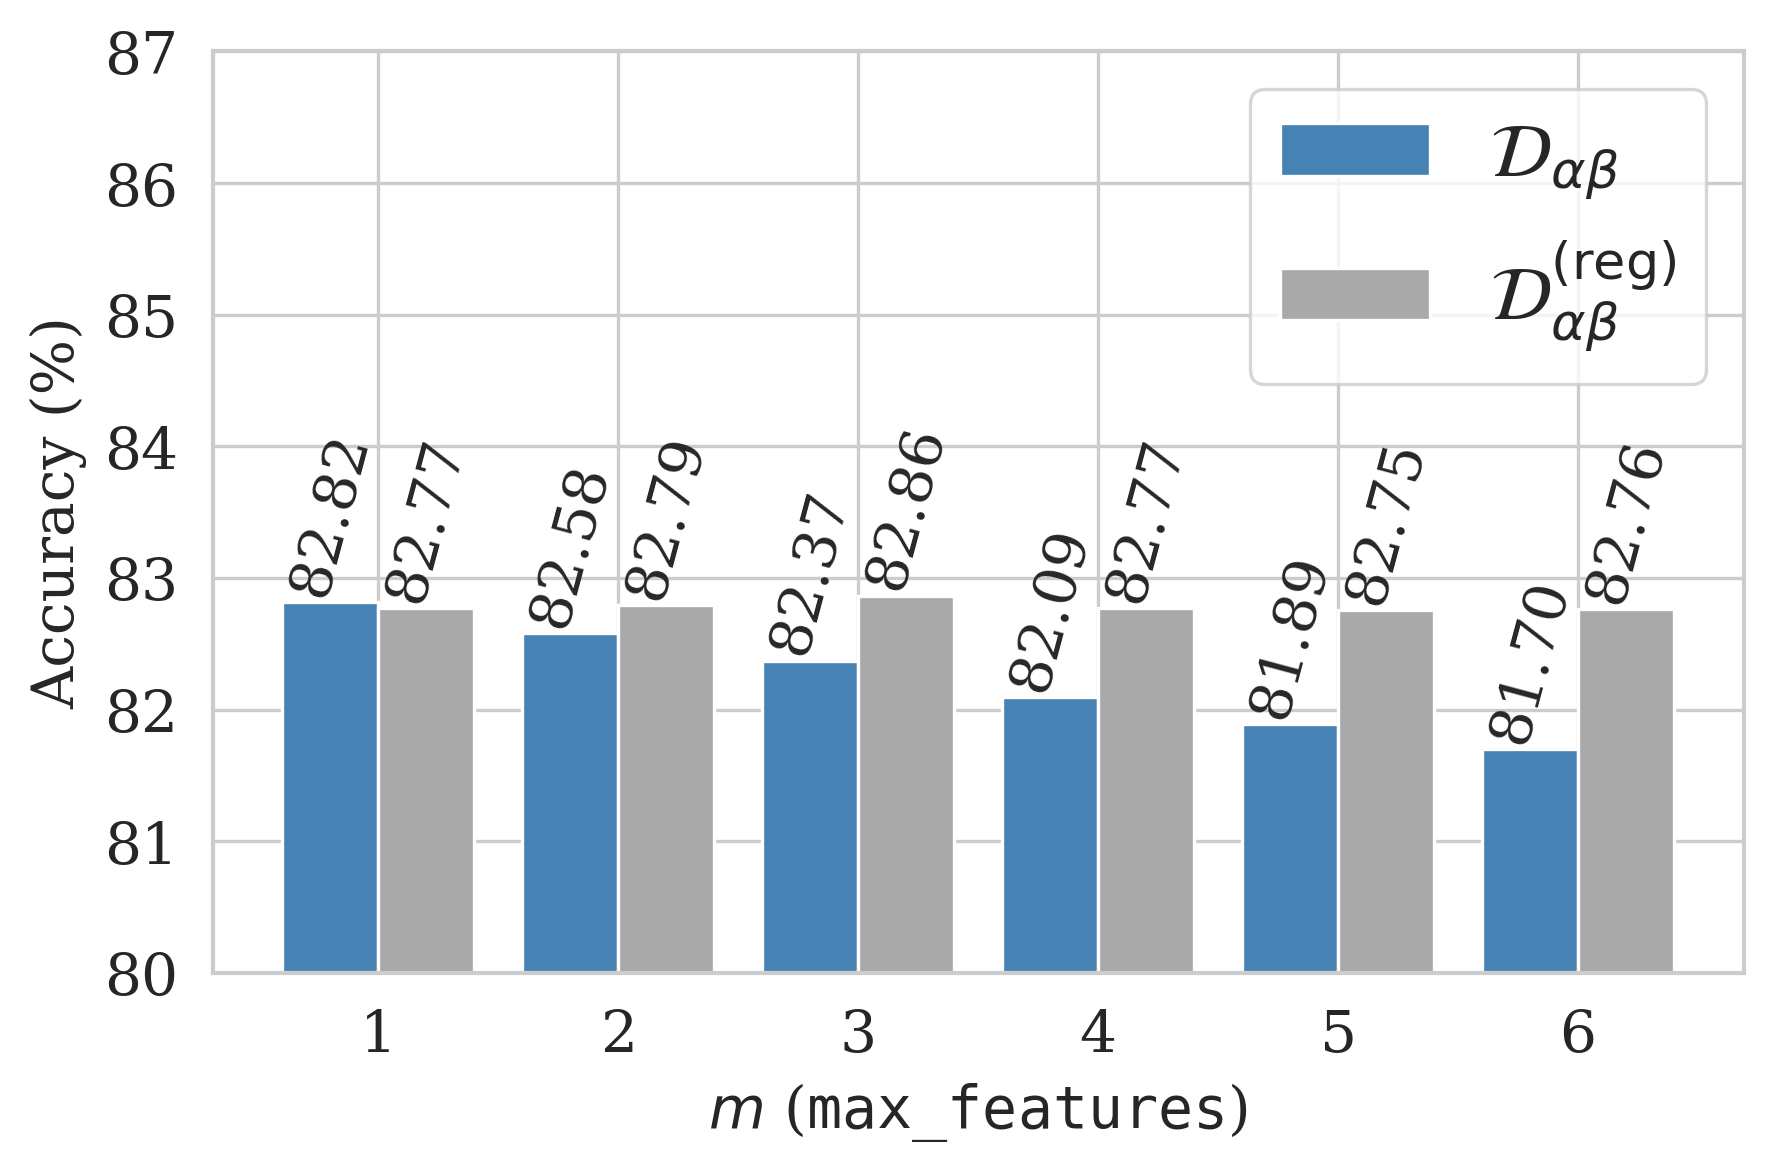

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

# 1. Convert proportions to percentages
accuracy_no_const_percent = [val * 100 for val in accuracy_no_const]
accuracy_const_percent    = [val * 100 for val in accuracy_const]

# Set a professional plot style with seaborn
#sns.set(style="whitegrid", context="paper")
fsize = 14  # Base font size for labels and ticks

# --- Create figure ---
# Use a larger figure size with high DPI and a white background
plt.figure(dpi=300, facecolor="white")

# # 2. Use real LaTeX for all text
# rcParams['text.usetex']         = True
# rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# rcParams['font.family']         = 'serif'
# rcParams['font.serif']          = ['Latin Modern Roman', 'Computer Modern Roman']
# rcParams['pdf.use14corefonts']  = False

# # 3. Seaborn style (LaTeX will handle the font family)
# sns.set(style="whitegrid", context="paper")
# fsize = 25

# 4. X values for bars (assume len(accuracy_no_const_percent) == 6)
x_values  = np.arange(1, len(accuracy_no_const_percent) + 1)
bar_width = 0.4

#plt.figure(figsize=(10, 6), facecolor="white")

# 5. Plot bars (legend labels in math mode is fine)
bars1 = plt.bar(
    x_values - bar_width / 2,
    accuracy_no_const_percent,
    width=bar_width,
    label=r'$\mathcal{D}_{\alpha \beta}$',
    color='steelblue',
    alpha=1
)
bars2 = plt.bar(
    x_values + bar_width / 2,
    accuracy_const_percent,
    width=bar_width,
    label=r'$\mathcal{D}_{\alpha \beta}^{(\mathrm{reg})}$',
    color='darkgray',
    alpha=1
)

# 6. Annotate bars (escape '%' as '\%' for LaTeX)
for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',   # <-- ESCAPE percent here
        ha='center',
        va='bottom',
        fontsize=fsize,
        rotation=75
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}',   # <-- ESCAPE percent here
        ha='center',
        va='bottom',
        fontsize=fsize,
        rotation=75
    )

# 7. Labels and legend (all in LaTeX mode)
plt.xlabel(r'$m$ ($\mathtt{max\_features}$)', fontsize=fsize)
plt.ylabel(r'Accuracy (%)', fontsize=fsize)  # <-- ESCAPE '%' here

# tick_labels = [
#     r'$\mu_i$',           # mu with subscript i
#     r'$\tilde{\mu}_i$',   # tilde-mu with subscript i
#     r'$\mathrm{Min}_i$',  # “Min” in upright shape with subscript i
#     r'$\mathrm{Max}_i$',  # “Max” in upright shape with subscript i
#     r'$\alpha_i$',        # alpha with subscript i
#     r'$\beta_i$'          # beta with subscript i
# ]
plt.xticks(x_values, fontsize=fsize)

plt.yticks(fontsize=fsize)
plt.legend(loc='upper right', fontsize=18)

# 8. Adjust y‐axis 
plt.ylim(80, 87)   

plt.tight_layout()

# 9. Save outputs (with a little padding so “C” isn’t clipped)
plt.savefig("max_features_iter_bar_with_values.eps",
            format="eps", dpi=300, pad_inches=0.1, bbox_inches='tight')




#### qed

In [ ]:
print("qed")